# Logistic Regression 

### Classification Problem

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pickle

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

In [4]:
# load the churn dataset divided into train and test samples - prepared and saved earlier
# before encoding of categorical predictors X

churn_train = pd.read_pickle('data/churn_train.pkl')
churn_test = pd.read_pickle('data/churn_test.pkl')

churn_train.head()

,customer_id,customer_age,customer_gender,customer_number_of_dependents,customer_education,customer_civil_status,customer_salary_range,customer_relationship_length,customer_available_credit_limit,credit_card_classification,...,period_inactive,contacts_in_last_year,credit_card_debt_balance,remaining_credit_limit,transaction_amount_ratio,total_transaction_amount,total_transaction_count,transaction_count_ratio,average_utilization,account_status
3681,425655,47,Unknown,4,Graduate,Married,60-80K,34,9261.0,Blue,...,3,0,1605,7656.0,0.571,8670,44,0.419,0.173,0
4863,533755,62,F,1,High School,Single,below 40K,36,1930.0,Blue,...,3,4,0,1930.0,0.331,1971,45,0.250,0.000,1
7575,775601,48,F,1,Unknown,Unknown,40-60K,36,2447.0,Blue,...,1,3,1991,456.0,0.719,4228,82,0.708,0.814,0
8249,837342,47,M,4,High School,Married,80-120K,37,2888.0,Blue,...,3,3,0,2888.0,0.717,4345,75,0.786,0.000,0
4723,521251,49,Unknown,3,Graduate,Married,below 40K,43,2174.0,Blue,...,3,2,785,1389.0,0.657,3890,78,0.660,0.361,0


## Logit model

Estimate the first model. Similarly as for a Linear Regression we can use the methods from the `statsmodels` library which also allows estimating a logistic regression model providing its formula and automatically recoding categorical predictors into dummies.

The model formula is given in the `Y ~ X1 + X2 + ... Xp`

In [7]:
churn_logit1 = smf.logit(
    formula = 'account_status ~ customer_available_credit_limit',
    data = churn_train
).fit()   # fit method estimates the coefficients

Optimization terminated successfully.
         Current function value: 0.440671
         Iterations 6


---
Alternatively, without specifying a formula, which is useful in the case of multiple variables, including decoded qualitative ones.

---

In [11]:
X = sm.add_constant(churn_train['customer_available_credit_limit'])
churn_logit1 = sm.Logit(churn_train['account_status'], X).fit()

# however, Logit function requires all variables to be numeric
# so we need to convert categorical variables into dummies

# Logit function DOES allow for categorical variables but they need to be 
# specified as such in the formula

Optimization terminated successfully.
         Current function value: 0.440671
         Iterations 6


In [13]:
print(churn_logit1.summary())

                           Logit Regression Results                           
Dep. Variable:         account_status   No. Observations:                 7088
Model:                          Logit   Df Residuals:                     7086
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Oct 2025   Pseudo R-squ.:               0.0003369
Time:                        18:21:58   Log-Likelihood:                -3123.5
converged:                       True   LL-Null:                       -3124.5
Covariance Type:            nonrobust   LLR p-value:                    0.1468
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -1.6236      0.039    -42.134      0.000      -1.699      -1.548
customer_available_credit_limit -3.025e-06   2.21e-06     -1.370    

---
In the lower part of results we can see estimates of individual model parameters (only two here), their standard errors, t statistics, their p-values and 95% confidence intervals.

It can be seen that `customer_available_credit_limit` DOES NOT significantly affect the risk of churning having p-value (`P>|z|`) = 0.171

On top of the results we also have the displayed value:
* `Pseudo R-squ.` : Multiple R-squared: 0.0000003369
* `LLR p-value` : testing the joint significance of the model (based on the comparison of `Log-Likelihood` and `LL-Null`)

In [16]:
# Model with all variables
# ! create a formula automatically ensuring that all categorical variables
# are treated properly

# it is only possible within the logit() function 

churn_train2 = churn_train.drop('customer_id', axis = 1)

churn_logit2 = smf.logit(
    formula = 'account_status ~ ' + ' + '.join(f'C({col})' if churn_train2[col].dtype == 'object' else col for col in churn_train2.columns if col != 'account_status'),
    data = churn_train2
).fit()

print(churn_logit2.summary())

Optimization terminated successfully.
         Current function value: 0.273312
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         account_status   No. Observations:                 7088
Model:                          Logit   Df Residuals:                     7054
Method:                           MLE   Df Model:                           33
Date:                Sat, 18 Oct 2025   Pseudo R-squ.:                  0.3800
Time:                        18:39:33   Log-Likelihood:                -1937.2
converged:                       True   LL-Null:                       -3124.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  3.5582   

---
* `Pseudo R-squ.` increased to 0.380
* the whole model is now jointly significant - `LLR p-value`

In [20]:
# if you are interested in the odds-ratios
np.exp(churn_logit2.params)

# (of course it does not make sense for the intercept term)

Intercept                                 35.100793
customer_gender[T.M]                       0.587375
customer_gender[T.Unknown]                 1.001904
customer_education[T.Uneducated]           1.064623
customer_education[T.High School]          0.960686
customer_education[T.College]              0.836559
customer_education[T.Graduate]             0.918880
customer_education[T.Post-Graduate]        1.278999
customer_education[T.Doctorate]            1.422124
customer_civil_status[T.Married]           0.716026
customer_civil_status[T.Single]            1.148224
customer_civil_status[T.Unknown]           1.205895
customer_salary_range[T.below 40K]         1.028800
customer_salary_range[T.40-60K]            0.987502
customer_salary_range[T.60-80K]            0.924975
customer_salary_range[T.80-120K]           1.297488
customer_salary_range[T.120K and more]     1.718336
credit_card_classification[T.Gold]         4.446365
credit_card_classification[T.Platinum]     4.818443
credit_card_

### Predict Logit

In [22]:
# lets see how to predict probabilities of account_status = closed (1) for the 
# test dataset 
# in case of logit() function result the method .predict() returns the probabilities for 1

predictions_churn_logit2 = churn_logit2.predict(
    churn_test.drop(['account_status', 'customer_id'], axis = 1
))

predictions_churn_logit2.head()

3987    0.000900
887     0.031183
7472    0.013160
3449    0.005081
6708    0.004330
dtype: float64

## Probit model

In [34]:
# in a similar manner we can apply the probit model 
# with the probit() function

churn_probit2 = smf.probit(
    formula = 'account_status ~ ' + ' + '.join(f'C({col})' if churn_train2[col].dtype == 'object' else col for col in churn_train2.columns if col != 'account_status'),
    data = churn_train2
).fit()

print(churn_probit2.summary())

# if LLR p-value < alpha : then all Xi are jointly significant

Optimization terminated successfully.
         Current function value: 0.278358
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:         account_status   No. Observations:                 7088
Model:                         Probit   Df Residuals:                     7054
Method:                           MLE   Df Model:                           33
Date:                Sat, 18 Oct 2025   Pseudo R-squ.:                  0.3685
Time:                        20:52:48   Log-Likelihood:                -1973.0
converged:                       True   LL-Null:                       -3124.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  1.6756   

In [36]:
# for probit there are no odd-ratios but you can get the marginal effects

churn_probit2_me = churn_probit2.get_margeff()

print(churn_probit2_me.summary())

       Probit Marginal Effects       
Dep. Variable:         account_status
Method:                          dydx
At:                           overall
                                            dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
customer_gender[T.M]                      -0.0439      0.011     -3.845      0.000      -0.066      -0.022
customer_gender[T.Unknown]                -0.0030      0.013     -0.237      0.813      -0.028       0.022
customer_education[T.Uneducated]           0.0064      0.013      0.501      0.616      -0.019       0.031
customer_education[T.High School]         -0.0039      0.012     -0.324      0.746      -0.028       0.020
customer_education[T.College]             -0.0116      0.014     -0.801      0.423      -0.040       0.017
customer_education[T.Graduate]            -0.0063      0.011     -0.570      0.569      -0.028     

In [38]:
# generate predicted probabilities of account_status = closed (1) for the test dataset

predictions_churn_probit2 = churn_probit2.predict(
    churn_test.drop(['account_status', 'customer_id'], axis=1)
)

predictions_churn_probit2.head()

3987    0.000089
887     0.037771
7472    0.011860
3449    0.003271
6708    0.012289
dtype: float64

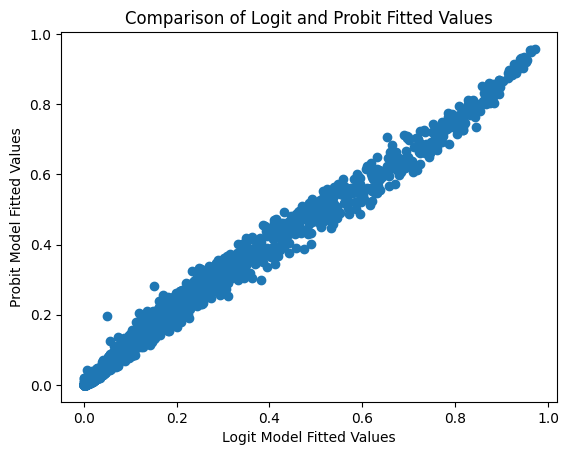

Correlation: 0.9945216959277705


In [40]:
plt.scatter(
    predictions_churn_logit2, predictions_churn_probit2
)
plt.xlabel('Logit Model Fitted Values')
plt.ylabel('Probit Model Fitted Values')
plt.title('Comparison of Logit and Probit Fitted Values')
plt.show()

# compute the correlation
correlation = np.corrcoef(
    predictions_churn_logit2,
    predictions_churn_probit2
)[0, 1]
print('Correlation:', correlation)

In [42]:
# compare also the predictions converted into "0" and "1"
# with the cut-off level of 0.5

# convert predicted probs into binary labels (0 or 1)
logit_classification = np.where(predictions_churn_logit2 > 0.5, 1, 0)
probit_classification = np.where(predictions_churn_probit2 > 0.5, 1, 0)

# and create a contingency table
contingency_table = pd.crosstab(
    logit_classification,
    probit_classification,
    rownames = ['Logit Model'],
    colnames = ['Probit Model']
)

print(contingency_table)

# only 44 observations classified differently

Probit Model     0    1
Logit Model            
0             2703   10
1               34  292


In [44]:
contingency_table

Probit Model,0,1
Logit Model,,
0,2703,10
1,34,292


## Multinomial Logistic Regression
The dependent variable Y has 3 levels, one take as reference, the other two as 0 and 1. When both are 0, 0 then it will be 1 for reference. 

Multinomial Logit is used when Y has more than 2 levels

---

The dataset `cards` contains data on customers who 2 years earlier received a credit card from a certain bank (e.g. as part of cross-selling, in installment purchases), but did not necessarily use it later. 

The bank opened a card account for each client. 

Now the bank wants to assess the status of this account.
The status of the card might have 3 different levels:

* `O` (like "open") means that the credit card is actively used and loans are paid. Bank makes a profit and it is worth keeping such an account. 
* `A` (like "attrition" means that the credit card was not used at all or was used sporadically. Mainatning such an account generates costs for the bank and it should be closed. 
* `C` (like "charge-off") means that the card is used by the customer but the loans are not repaid or are significantly delayed, such an account should be closed and transfered to the debt collection department.
                                                             
The dataset includes 7100 observations and 5 variables:

* `status` - card account status explained above
* `credit_limit` - average credit limit on other customer cards
* `n_contracts` - the total number of contracts in the customer's credit history (credit cards, cash, mortgage, car loans, etc.)
* `gender` -- gender of the client
* `utilization` - utilization of other customer credit cards (in %)

In [47]:
cards = pd.read_csv('data/credit_cards.csv')

cards.head()

,credit_limit,n_contracts,utilization,status,gender
0,5525,17,41.4,O,M
1,8245,15,45.5,O,M
2,7370,13,44.2,O,M
3,6480,19,26.3,O,M
4,6045,25,38.4,O,K


In [53]:
cards.isna().sum()

credit_limit    0
n_contracts     0
utilization     0
status          0
gender          0
dtype: int64

In [55]:
# convert qualitative variable into a category type
cards['gender'] = cards['gender'].astype('category')

# the outcome variable in a multinomial logit model has to be coded in python as numeric
# lets recode: O -> 0, A -> 1 and C -> 2

cards['status'] = cards['status'].map({'O' : 0, 'A' : 1, 'C' : 2})

In [57]:
# split the data randomly into train (70%) and test (30%)

cards_train, cards_test = train_test_split(
    cards,
    test_size = 0.3,
    stratify = cards['status'],
    random_state = 123 # keep constant for reproducibility
)

In [59]:
# save the train and test data in the current form as a pickle file

# for DataFrames we can simply use a function to_pickle()
# which however allows to save just a single object into a file

cards_train.to_pickle('data/cards_train.pkl')
cards_test.to_pickle('data/cards_test.pkl')

In [69]:
# estimate a multinomial logistic regression model
# using the training data (status is a dependent variable)

cards_mnlogit = smf.mnlogit(
    formula = 'status ~ credit_limit + n_contracts + utilization + C(gender)',
    data = cards_train
).fit()

print(cards_mnlogit.summary())

# the first level (0) is used as a reference   -> status = 0 in this case

Optimization terminated successfully.
         Current function value: 0.579152
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                 status   No. Observations:                 4970
Model:                        MNLogit   Df Residuals:                     4960
Method:                           MLE   Df Model:                            8
Date:                Sat, 18 Oct 2025   Pseudo R-squ.:                  0.4111
Time:                        21:43:29   Log-Likelihood:                -2878.4
converged:                       True   LL-Null:                       -4887.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
      status=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.8753      0.201    -24.199      0.000      -5.270      -4.480
C(gender)[T.M]   

In [65]:
# if one is interested in odds-ratios

np.exp(cards_mnlogit.params)

,0,1
Intercept,0.007633,7.645740
C(gender)[T.M],0.949555,0.961188
credit_limit,1.000237,0.999747
n_contracts,1.016400,0.924423
utilization,0.998186,1.013581


In [67]:
# marginal effects

cards_mnlogit_me = cards_mnlogit.get_margeff()

print(cards_mnlogit_me.summary())

       MNLogit Marginal Effects      
Dep. Variable:                 status
Method:                          dydx
At:                           overall
      status=0      dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
C(gender)[T.M]     0.0075      0.012      0.633      0.527      -0.016       0.031
credit_limit    1.222e-06   1.49e-06      0.819      0.413    -1.7e-06    4.15e-06
n_contracts        0.0051      0.001      7.850      0.000       0.004       0.006
utilization       -0.0010      0.000     -4.384      0.000      -0.001      -0.001
----------------------------------------------------------------------------------
      status=1      dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
C(gender)[T.M]    -0.0043      0.009     -0.498      0.618      -0.021       0.013
credit_limit    2.

In [71]:
# calculate the predictions (for the test sample)

cards_test_predictions = cards_mnlogit.predict(
    cards_test.drop('status', axis = 1)
)

cards_test_predictions.head()

,0,1,2
5484,0.152994,0.846890,0.000116
2126,0.087137,0.000924,0.911939
4683,0.110119,0.889833,0.000048
4065,0.731891,0.037028,0.231081
64,0.486429,0.014920,0.498651


In [75]:
# mnlogit_classification = np.where(cards_test_predictions > 0.5, 1, 0)

# # and create a contingency table
# contingency_table = pd.crosstab(
#     mnlogit_classification,
#     rownames = ['Logit Model'],
#     colnames = ['Probit Model']
# )

# print(contingency_table)

* these are predicted probs for each level 
* by default it is assumed that the level with the highest probability is predicted (e.g. "1" for row 1 and 3, "2" for rows 2 and 5 and "0" for row 4)